# Reading Data

In [34]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sktime.forecasting.all import temporal_train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import sktime
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
from functools import partial
from sklearn.model_selection import (TimeSeriesSplit, train_test_split, 
                                     cross_val_score)
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
import xgboost as xgb
from sklearn.metrics import make_scorer
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

In [35]:
def model_evaluate(y_test, y_pred,y_train, var):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = MeanAbsolutePercentageError(symmetric=False)
    mape = mape(y_test, y_pred)
    smape = MeanAbsolutePercentageError()
    smape_val = smape(y_test, y_pred)
    mase = mean_absolute_scaled_error(y_test, y_pred, y_train = y_train)
    return pd.DataFrame([[mae,mse,rmse,mape,smape_val,mase]],columns = ['MAE','MSE','RMSE','MAPE','sMAPE','MASE'],index= ['Test vs Pred - ' + var])

# Hyperopt Tuning with Regressor

In [ ]:
data_cad = pd.read_csv('CAD.csv',index_col=0)
data_cad.index = pd.to_datetime(data_cad.index)
data_cad['CADUSD_Shift']= data_cad['CADUSD'].shift()

In [36]:
data_cad

,CADUSD,YC/CAN5Y - Rate,YC/USA5Y - Rate,Change in Spot,Direction,CADUSD_Shift
Date,,,,,,
2004-08-23,1.3065,3.760000,3.42,0.0085,1,NaN
2004-08-24,1.3048,3.800000,3.46,-0.0017,0,1.3065
2004-08-25,1.3047,3.850000,3.46,-0.0001,0,1.3048
2004-08-26,1.3123,3.830000,3.46,0.0076,1,1.3047
2004-08-27,1.3104,3.810000,3.42,-0.0019,0,1.3123
...,...,...,...,...,...,...
2019-12-25,1.3142,1.640000,1.72,-0.0018,0,1.3160
2019-12-26,1.3124,1.633333,1.72,-0.0018,0,1.3142
2019-12-27,1.3073,1.626667,1.72,-0.0051,0,1.3124


In [37]:
X_cad, y_cad = data_cad[['YC/CAN5Y - Rate', 'YC/USA5Y - Rate','CADUSD_Shift']], data_cad['CADUSD']

In [38]:
X_train, X_test = X_cad.iloc[:int(train_test_size*len(X_cad))], X_cad.iloc[int(train_test_size*len(X_cad)):]
y_train, y_test = y_cad.iloc[:int(train_test_size*len(y_cad))], y_cad.iloc[int(train_test_size*len(y_cad)):]

In [39]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from functools import partial
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (TimeSeriesSplit, train_test_split, 
                                     cross_val_score)
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
import xgboost as xgb

from sklearn.metrics import make_scorer

# MAPE computation
def mape(y, yhat, perc=True):
    n = len(yhat.index) if type(yhat) == pd.Series else len(yhat)    
    mape = []
    for a, f in zip(y, yhat):
        # avoid division by 0
        if f > 1e-9:
            mape.append(np.abs((a - f)/a))
    mape = np.mean(np.array(mape))
    return mape * 100. if perc else mape


def train_xgb(params, X_train, y_train):
    """
    Train XGBoost regressor using the parameters given as input. The model
    is validated using standard cross validation technique adapted for time series
    data. This function returns a friendly output for the hyper parameter optimization
    module.
    
    Parameters
    ----------
    params: dict with the parameters of the XGBoost regressor. For complete list see: 
            https://xgboost.readthedocs.io/en/latest/parameter.html
    X_train: pd.DataFrame with the training set features
    y_train: pd.Series with the training set targets    
    
    Returns
    -------
    dict with keys 'model' for the trained model, 'status' containing the hyperopt
    status string and 'loss' with the RMSE obtained from cross-validation
    """
    
    n_estimators = int(params["n_estimators"])
    max_depth= int(params["max_depth"])

    try:
        model = xgb.XGBRegressor(n_estimators=n_estimators, 
                                 max_depth=max_depth, 
                                 learning_rate=params["learning_rate"],
                                 subsample=params["subsample"])

        result = model.fit(X_train, 
                           y_train.values.ravel(),
                           eval_set=[(X_train, y_train.values.ravel())],
                           early_stopping_rounds=50,
                           verbose=False)
        
        # cross validate using the right iterator for time series
        cv_space = TimeSeriesSplit(n_splits=5)
        cv_score = cross_val_score(model, 
                                   X_train, y_train.values.ravel(), 
                                   cv=cv_space, 
                                   scoring=mape_scorer)

        rmse = np.abs(np.mean(np.array(cv_score)))
        return {
            "loss": rmse,
            "status": STATUS_OK,
            "model": model
        }
        
    except ValueError as ex:
        return {
            "error": ex,
            "status": STATUS_FAIL
        }
    
def optimize_xgb(X_train, y_train, max_evals=10):
    """
    Run Bayesan optimization to find the optimal XGBoost algorithm
    hyperparameters.
    
    Parameters
    ----------
    X_train: pd.DataFrame with the training set features
    y_train: pd.Series with the training set targets
    max_evals: the maximum number of iterations in the Bayesian optimization method
    
    Returns
    -------
    best: dict with the best parameters obtained
    trials: a list of hyperopt Trials objects with the history of the optimization
    """
    
    space = {
        "n_estimators": hp.quniform("n_estimators", 100, 1000, 10),
        "max_depth": hp.quniform("max_depth", 4, 8, 1),
        "learning_rate": hp.loguniform("learning_rate", -5, 1),
        "subsample": hp.uniform("subsample", 0.8, 1),
        "gamma": hp.quniform("gamma", 0, 100, 1)
    }

    objective_fn = partial(train_xgb, 
                           X_train=X_train, 
                           y_train=y_train)
    
    trials = Trials()
    best = fmin(fn=objective_fn,
                space=space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials)

    # evaluate the best model on the test set
    print(f"""
    Best parameters:
        learning_rate: {best["learning_rate"]} 
        n_estimators: {best["n_estimators"]}
        max_depth: {best["max_depth"]}
        sub_sample: {best["subsample"]}
        gamma: {best["gamma"]}
    """)
    return best, trials

In [40]:
mape_scorer = make_scorer(mape, greater_is_better=False)
best, trials = optimize_xgb(X_train, y_train, max_evals=50)

100%|█████████| 50/50 [04:59<00:00,  5.99s/trial, best loss: 1.3517160408944957]

    Best parameters:
        learning_rate: 0.018118140064206284 
        n_estimators: 370.0
        max_depth: 4.0
        sub_sample: 0.8679220734618943
        gamma: 61.0
    


In [41]:
best

{'gamma': 61.0,
 'learning_rate': 0.018118140064206284,
 'max_depth': 4.0,
 'n_estimators': 370.0,
 'subsample': 0.8679220734618943}

In [42]:
model = xgb.XGBRegressor(n_estimators=int(best['n_estimators']), 
                                 max_depth=int(best['max_depth']), 
                                 learning_rate=best["learning_rate"],
                                 subsample=best["subsample"])

result = model.fit(X_train, 
                   y_train.values.ravel(),
                   eval_set=[(X_train, y_train.values.ravel())],
                   early_stopping_rounds=50,
                   verbose=False)

In [43]:
ypred_train = model.predict(X_train)
ypred_test = model.predict(X_test)

<AxesSubplot:xlabel='Date'>

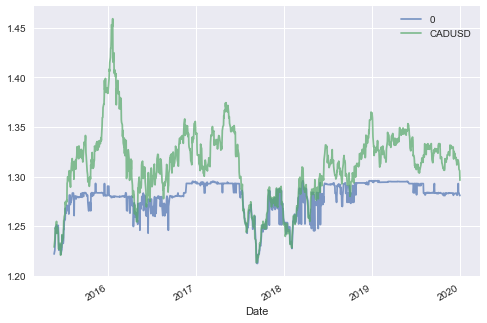

In [44]:
pd.concat(
    [
        pd.Series(ypred_test, index=y_test.index),
        y_test,
    ], axis=1
).plot(alpha=0.7)

In [45]:
MAPE_func = sktime.performance_metrics.forecasting.MeanAbsolutePercentageError(symmetric=False)

In [46]:
print('mse train: {}'.format( round(MAPE_func(y_train, ypred_train),3)))
print('mse test:  {}'.format( round(MAPE_func(y_test, ypred_test),3)))

mse train: 0.004
mse test:  0.024


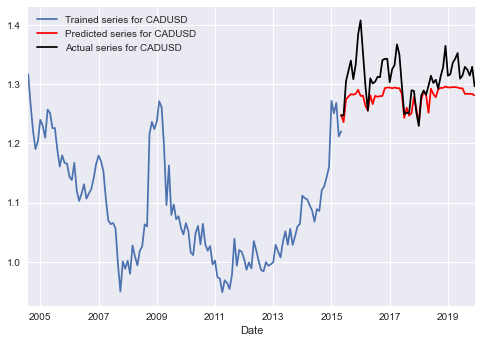

In [49]:
yhat4 = pd.Series(ypred_test, index=y_test.index)
y_train.resample('M').last().plot(label='Trained series for CADUSD')
yhat4.resample('M').last().plot(color='red',label='Predicted series for CADUSD')
y_test.resample('M').last().plot(color = 'black',label='Actual series for CADUSD')
plt.legend()

In [48]:
model_evaluate(y_test,yhat4 ,y_train, 'CADUSD')

,MAE,MSE,RMSE,MAPE,sMAPE,MASE
Test vs Pred - CADUSD,0.032633,0.001753,0.041872,0.024416,0.024903,6.855756
